# On the advantage of assuming constant mass flow rates in discretized dynamic material flow models. 

by Oliver Cencic, Rudolf Frühwirth

2025-06-20

This code is based on code published by Dirk Lauinger (version v1.0.0, from Oct 20, 2020, https://doi.org/10.5281/zenodo.4110806) used to generate Figures 4 and 5 for the paper "A General Theory for Stock Dynamics of Populations and Built and Natural Environments", written by Dirk Lauinger, Romain G. Billy, Daniel B. Müller, Felipe Vásquez.

## General model definitions

In [10]:
# -- import relevant libraries
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import weibull_min
from scipy.stats import triang
from scipy.stats import uniform
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.signal import convolve

In [11]:
# -- define problem parameters

T = 100     # length of planning horizon
N = 10      # number of periods 
dt = T/N    # duration of each period (time)

# time steps
t = np.arange(0,T+dt,dt) # gives an array 0 to T with step dt
# Note: with np.arange(start, stop), values are generated within the half-open interval [start, stop).
# Thus "stop" is not included!

# -- fine time grid
dt1 = 0.01
t1 = np.arange(0, T, dt1)
N1 = len(t1)

#print(t1)
#print(N1)


In [12]:
# -- define data processing for displaying piecewise constant functions

hor = 1
# 0...values assigned to end of the periods
# 1...values assigned as horizontal line to complete period

def dp(data, flag):
    if flag:
        data2 = []
        for element in data:
            data2.append(element)
            data2.append(element)
    else:
        data2 = data
    
    return data2

t2 = dp(t,hor)

if hor:
    t2 = t2[1:-1]
else:
    t2 = t2[1:]

In [13]:
# -- define lifetime distribution

dist = 2

if dist == 1:   # truncated normal
    mu = 10     # mean lifetime (time)
    sig = 3     # standard deviation (time)
    a = (0 - mu) / sig
    def pdf(x):
        return truncnorm.pdf(x,a,np.inf,mu,sig)
    def cdf(x):
        return truncnorm.cdf(x,a,np.inf,mu,sig)
    mean = truncnorm.mean(a,np.inf,mu,sig)
    
elif dist == 2:     # triangular
    a = 0           # left point of triangular distribution
    c = 0           # peak of triangular distribution
    b = 40           # right point of triangular distribution
    c = (c-a)/(b-a) # normalized peak of triangular distribution (between 0 and 1)
    offset = a      # offset of triangular distribution 
    scale = b-a     # length of triangular distribution
    def pdf(x):
        return triang.pdf(x,c,offset,scale)
    def cdf(x):
        return triang.cdf(x,c,offset,scale)  
    mean = triang.mean(c,offset,scale)
    
elif dist == 3:     # weibull
    k = 2           # k of weibull
    lam = 30         # lambda of weibull distribution
    off = 0         # offset of weibull distribution
    def pdf(x):
        return weibull_min.pdf(x,k,off,lam)
    def cdf(x):
        return weibull_min.cdf(x,k,off,lam)
    mean = weibull_min.mean(k,off,lam)
    
else:               # uniform
    off = 0         # offset of uniform distribution
    scale = 10      # lenght of uniform distribution
    def pdf(x):
        return uniform.pdf(x,off,scale)
    def cdf(x):
        return uniform.cdf(x,off,scale)
    mean = uniform.mean(off,scale)

# convolution of uniform input with selected LTD
def con_pdf(x,dx):
    return (cdf(x)-cdf(x-np.minimum(x,dx)))/dx

# numerical integration of con_pdf in the interval [x,x+dx]
def con_p(x,dx):
    n = 100
    di = dx/n
    P = 0
    for i in np.arange(x+di/2,x+dx,di):  # numerical central integration
        P = P + con_pdf(i,dx)*di
    return P

In [14]:
# build lifetime matrices

# Paper (Dirk Lauinger)
# uses pdf at start of period and 'normalization' to LTD of period
Lo = np.zeros((N,N))
for n in range(N):
    Lo = Lo + np.diag(np.ones(N - n)*pdf(n*dt), k = -n)
Lo = Lo/Lo[:,0].sum()*cdf(N*dt) # normalization; "*cdf(N*dt)" is necessary if LTD is longer than T!

# OC (Oliver Cencic)
# uses difference of cdf at end of period minus cdf at start of period
# assumes that all inputs appear at start of period. The input and LDT from period 1 are used to
# compute output of period 1.
Ls = np.zeros((N,N))
for n in range(N):
    Ls = Ls + np.diag(np.ones(N - n)*(cdf(t[n+1])-cdf(t[n])), k = -n)  

# SP (Stefan Pauliuk)
# also uses difference of cdf at end of period minus cdf at start of period
# assumes that all inputs appear at end of period. Thus, the input and the LTD from period 1
# are used to compute the outout of period 2! No output in period 1!
# Equivalent to shifting the LTD one period to the right (compared to OC).
Le = np.zeros((N,N))
for n in range(1,N):
    Le = Le + np.diag(np.ones(N - n)*(cdf(t[n])-cdf(t[n-1])), k = -n)
    
# OC, uniform input
# also uses difference of cdf at end of period minus cdf at start of period
# assumes that all inputs appear uniformly distributed over the period.
# The input and LDT from period 1 are then used to compute output of period 1. 
Lu = np.zeros((N,N))
for n in range(N):
    Lu = Lu + np.diag(np.ones(N - n)*con_p(t[n],dt), k = -n)

# computation of d
L_mean = mean
d = 1/L_mean

## Lifetime vs. death rate (stock driven model)

The figures created in this section compare the evolution of inflows and outflows under a time independent lifetime distribution and a constant death rate, equal to the inverse of the mean lifetime, for a model with logistic stock growth.

In [15]:
# -- define the in- and outflows as a function of the stock and the death rate or the lifetime

# Important notes to indexing slices:
# [1:5] will start with the 1st element and will end BEFORE the 5th element!

def dS(S):
    return np.diff(S)   # calculate stock change

# death rate approach
def OD(S, d):
    return d*S[:-1]*dt
    # return d*S[1:] # original => wrong?
    # would mean that d% of what is in stock at the END of period is
    # release during the period.

def ID(S, d):
    return dS(S) + OD(S, d)

# lifetime approach
def IL(S, L):
    # apply Equation (8)
    return np.linalg.solve(np.identity(N) - L, dS(S))
    
def OL(S, L):
    return IL(S, L) - dS(S)

# Info:
# O and I deliver the number of individuals, kg, ... in an interval dt. This is similar to a mass function. 
# In the later graphs, O and I are devided by dt to get an analogon of a density function.

In [16]:
# -- define stock

S_max = 1

# logistic stock growth
T1 = 100
s = 15/T1   # shape factor for the logistic stock growth (1/time)
m = 0.5*T1  # mean value of the logistic function (time)

# stock evolution

# Define S(t)
def St(t):
    return S_max/(1 + np.exp(-s*(t-m)))

# Derivative of S(t)
def dS_dt(t):
    s = St(t)
    return 0.15 * s * (1 - s)

S = St(t)
S1 = St(t1)


In [17]:
# -- Simplify used variable names

#print(dS(S))

Od = OD(S, d)
Oo = OL(S, Lo)
Os = OL(S, Ls)
Oe = OL(S, Le)
Ou = OL(S, Lu)

Dd = Od/S[:-1]
Do = Oo/S[:-1]
Ds = Os/S[:-1]
De = Oe/S[:-1]
Du = Ou/S[:-1]

Id = ID(S, d)
Io = IL(S, Lo)
Is = IL(S, Ls)
Ie = IL(S, Le)
Iu = IL(S, Lu)

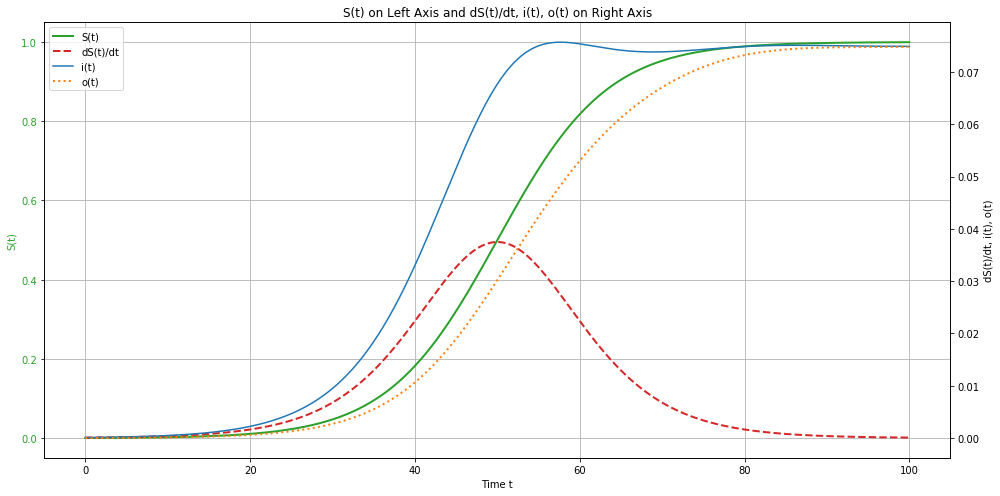

In [18]:
# -- continuous solution

# Precompute arrays
dsdt_values = dS_dt(t1)

# Create l(t)
l_values = pdf(t1)

# Normalize l(t) to ensure its integral over time is 1
l_values /= np.sum(l_values) * dt1

# Initial guess for i(t)
i_values = np.copy(dsdt_values)

# Iterative fixed-point method
for iteration in range(20):  # More iterations for better convergence
    conv = convolve(i_values, l_values, mode='full')[:N1] * dt1
    i_values = dsdt_values + conv

# After solving, compute o(t)
o_values = conv

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(14,7))

# Left y-axis: S(t)
color1 = 'tab:green'
ax1.set_xlabel('Time t')
ax1.set_ylabel('S(t)', color=color1)
ax1.plot(t1, St(t1), color=color1, label='S(t)', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

# Right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('dS(t)/dt, i(t), o(t)', color='black')

# Plot on right axis
ax2.plot(t1, dsdt_values, '--', label='dS(t)/dt', color='tab:red', linewidth=2)
ax2.plot(t1, i_values, '-', label='i(t)', color='tab:blue', linewidth=1.5)
ax2.plot(t1, o_values, ':', label='o(t)', color='tab:orange', linewidth=2)
ax2.tick_params(axis='y', labelcolor='black')

# Title
plt.title('S(t) on Left Axis and dS(t)/dt, i(t), o(t) on Right Axis')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()
plt.show()


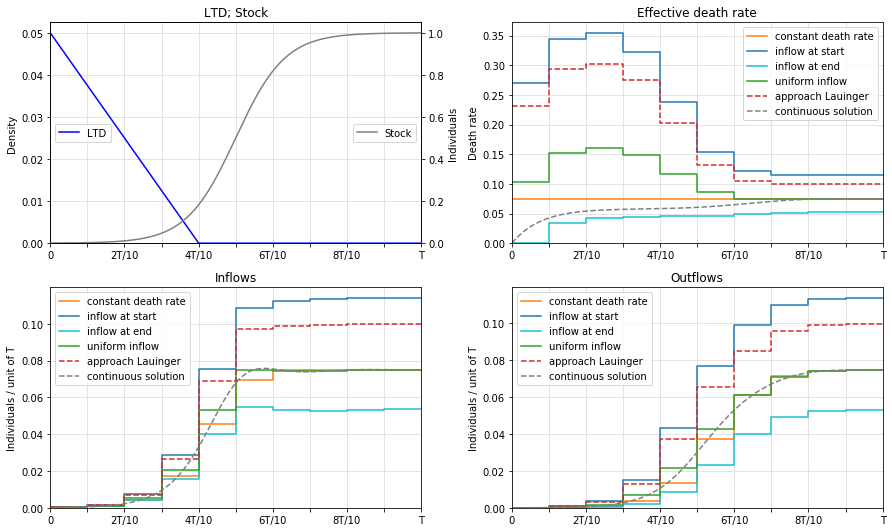

In [19]:
# -- plot the figure
fig = plt.figure(figsize = (12.5, 7.5))
plt.rcParams.update({'font.size': 10})

# Stock
ax1=[]
#ax1 = plt.subplot(221, fc = 'w')
ax1.append(plt.subplot(221, fc = 'w'))
plt.plot(t1,pdf(t1), color='blue', label = 'LTD')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
bottom, top = ax1[0].get_ylim()
ax1[0].set_ylim(0,top)
plt.ylabel('Density')
plt.title('LTD; Stock')
plt.grid(color='gainsboro')
plt.legend(facecolor = 'w', fontsize = '10', loc = 'center left')

#create plot on secondary y-axis of upper subplot
ax1.append(ax1[0].twinx())
plt.plot(t1, S1, color='grey', label = 'Stock')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.ylabel('Individuals')
plt.legend(facecolor = 'w', fontsize = '10', loc = 'center right')

# Effective Death Rate
ax2 = plt.subplot(222, facecolor = 'w')
plt.plot(t2, dp(Dd/dt,hor), color = 'tab:orange', label = 'constant death rate')
plt.plot(t2, dp(Ds/dt,hor), color = 'tab:blue', label = 'inflow at start')
plt.plot(t2, dp(De/dt,hor), color = 'tab:cyan', label = 'inflow at end')
plt.plot(t2, dp(Du/dt,hor), color = 'tab:green', label = 'uniform inflow')
plt.plot(t2, dp(Do/dt,hor), color = 'tab:red', label = 'approach Lauinger', linestyle = '--')
plt.plot(t1, o_values/S1, color = 'grey', label = 'continuous solution', linestyle = '--')
plt.legend(facecolor = 'w', fontsize = '10', loc = 'upper right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.ylabel('Death rate')
plt.title('Effective death rate')
plt.grid(color='gainsboro')

# Inflows
ax3 = plt.subplot(223, facecolor = 'w')
plt.plot(t2, dp(Id/dt,hor), label = 'constant death rate', color = 'tab:orange')
plt.plot(t2, dp(Is/dt,hor), label = 'inflow at start', color = 'tab:blue')
plt.plot(t2, dp(Ie/dt,hor), label = 'inflow at end', color = 'tab:cyan')
plt.plot(t2, dp(Iu/dt,hor), label = 'uniform inflow', color = 'tab:green')
plt.plot(t2, dp(Io/dt,hor), label = 'approach Lauinger', color = 'tab:red', linestyle = '--')
plt.plot(t1, i_values, label='continuous solution', color = 'grey', linestyle = '--')
plt.legend(facecolor = 'w', fontsize = '10', loc = 'upper left')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.ylabel('Individuals / unit of T')
plt.title('Inflows')
plt.grid(color='gainsboro')

# Outflows
ax4 = plt.subplot(224, facecolor = 'w')
plt.plot(t2, dp(Od/dt,hor), label = 'constant death rate', color = 'tab:orange')
plt.plot(t2, dp(Os/dt,hor), label='inflow at start', color = 'tab:blue')
plt.plot(t2, dp(Oe/dt,hor), label='inflow at end', color = 'tab:cyan')
plt.plot(t2, dp(Ou/dt,hor), label='uniform inflow', color = 'tab:green')
plt.plot(t2, dp(Oo/dt,hor), label='approach Lauinger', color = 'tab:red', linestyle = '--')
plt.plot(t1, o_values, label='continuous solution', color='grey', linestyle = '--')
plt.legend(facecolor = 'w', fontsize = '10', loc = 'upper left')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.ylabel('Individuals / unit of T')
plt.title('Outflows')
plt.grid(color='gainsboro')
# optimize layout
fig.tight_layout()
#fig.savefig('Flows and stocks (stock-driven model).pdf',bbox_inches='tight')
#fig.savefig('Flows and stocks (stock-driven model).png',bbox_inches='tight', dpi=600)

## Lifetime (input driven model)

The figures created in this section compare the evolution of outflows and stocks under a time independent lifetime distribution for a model with various selectable inflow types 

In [20]:
# -- define the outflow and stock as a function of the input and the lifetime distribution

def O(I,L):
    return L.dot(I)

def dS(I,L):
    return(I-O(I,L))

def S(I,L):
    return np.append([0],np.cumsum(dS(I,L)))

def SD(I,D):
    return np.append([0],D.dot(I))

def OD(Sd,d):
    return Sd[:-1]*d*dt


In [21]:
# -- define input

inp = 5

if inp == 1: # continuous constant input
    I_cont = 10.0
    #I_rate = np.ones(len(t))*I_cont 
#    def I_rate(x):
#        return I_cont
    def I_rate(x):
        return np.array([I_cont for i in x])

elif inp == 2: # random input
    rd.seed(1)
    I_upper = 10.0
    I_lower = 5.0
    #I_rate = np.ones(len(t))   # pdf continous input function; unit mass per time
    #for i in range(N+1):
        #I_rate[i]=I_rate[i]*rd.uniform(I_lower,I_upper)
    def I_rate(x):
        return np.array([rd.uniform(I_lower,I_upper) for i in x])

elif inp == 3: # rising sinusoid
    A = 2.0
    omega = 2 * np.pi / 20
    B = 0.05
    C = 2.5
    def I_rate(x):
        i = A * np.sin(omega * x) + B * x + C
        i = np.maximum(i, 0)
        return i

elif inp == 4: # piecewise linear
    def I_rate(x):
        i = np.piecewise(
            x,
            [x<0, (x>=0)&(x<25), (x>=25)&(x<55), (x>=55)&(x<70), (x>=70)&(x<80), (x>=80)&(x<100), x>=100],
            [0, 2, 6, 4, 3, 1, 0]
        )
        return i
    
elif inp == 5: # polynom with 5 degrees
    def I_rate(x):
        i = -0.0000001212*np.power(x,5)+0.00002573*np.power(x,4)-0.001751*np.power(x,3)+0.03919*np.power(x,2)
        i = np.maximum(i, 0)
        return i

else: # logistic input growth
    I_max = 10
    T1 = 10
    s = 15/T1   # shape factor for the logistic stock growth (1/time)
    m = 0.5*T1  # mean value of the logistic function (time)
    #I_rate = I_max/(1 + np.exp(-s*(t-m)))
    def I_rate(x):
        return I_max/(1 + np.exp(-s*(x-m)))

# Compute N interval means as ndarrays
i_values = I_rate(t1)

mean_i = np.zeros(N)

for idx in range(N):
    start = t[idx]
    end = t[idx + 1]
    mask = (t1 >= start) & (t1 < end)
    mean_i[idx] = np.mean(i_values[mask])

I = mean_i*dt
#print(I)

# ???
D = np.zeros((N,N))
for n in range(N-1):
    D = D + np.diag(np.ones(N - n)*(1-d*dt)**n, k = -n)

#print(d)

In [22]:
# -- Simplify used variable names

Sd = SD(I,D)
So = S(I, Lo)
Ss = S(I, Ls)
Se = S(I, Le)
Su = S(I, Lu)

Od = OD(Sd, d)
Oo = O(I, Lo)
Os = O(I, Ls)
Oe = O(I, Le)
Ou = O(I, Lu)

# starting with [1:] because S, in most cases, is zero at t=0
Dd = Od[1:]/Sd[1:N]
Do = Oo[1:]/So[1:N]
Ds = Os[1:]/Ss[1:N]
De = Oe[1:]/Se[1:N]
Du = Ou[1:]/Su[1:N]

#print(I)
#print(Ou)
#print(I-Ou)
#print(Su)

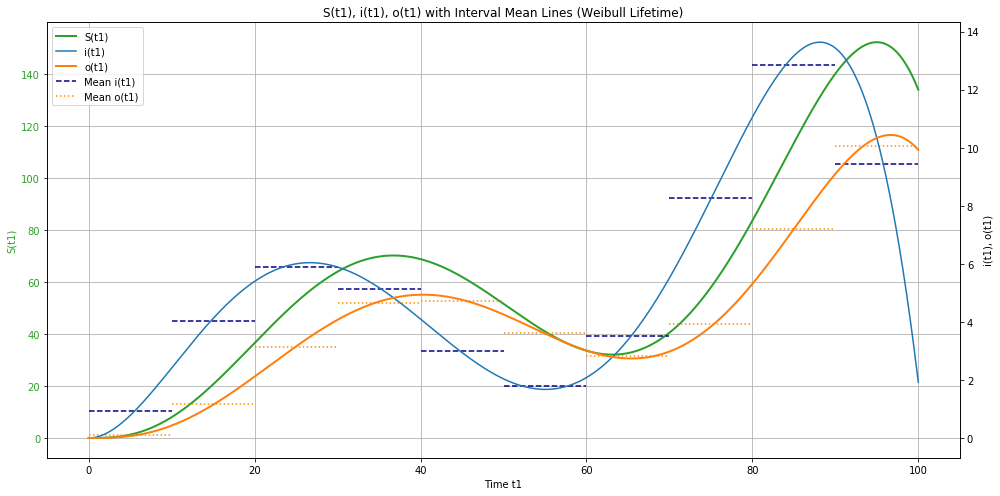

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.stats import weibull_min

# Output o(t1)
o_values = convolve(i_values, l_values, mode='full')[:N1] * dt1

# Stock S(t1)
s_values = np.cumsum(i_values - o_values) * dt1

# Compute N interval means as ndarrays
mean_o = np.zeros(N)

for idx in range(N):
    start = t[idx]
    end = t[idx + 1]
    mask = (t1 >= start) & (t1 < end)
    mean_o[idx] = np.mean(o_values[mask])

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 7))

# Left y-axis: S(t1)
ax1.set_xlabel('Time t1')
ax1.set_ylabel('S(t1)', color='tab:green')
ax1.plot(t1, s_values, label='S(t1)', color='tab:green', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:green')
ax1.grid(True)

# Right y-axis: i(t1), o(t1)
ax2 = ax1.twinx()
ax2.set_ylabel('i(t1), o(t1)', color='black')
ax2.plot(t1, i_values, label='i(t1)', color='tab:blue', linewidth=1.5)
ax2.plot(t1, o_values, label='o(t1)', color='tab:orange', linewidth=2)

# Draw horizontal mean lines for each interval
# Compute N interval means as ndarrays
interval_edges = np.linspace(0, T, N+1)
for idx in range(N):
    start = interval_edges[idx]
    end = interval_edges[idx + 1]
    ax2.hlines(mean_i[idx], start, end, colors='navy', linestyles='dashed', linewidth=1.5, label='Mean i(t1)' if idx == 0 else "")
    ax2.hlines(mean_o[idx], start, end, colors='darkorange', linestyles='dotted', linewidth=1.5, label='Mean o(t1)' if idx == 0 else "")

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('S(t1), i(t1), o(t1) with Interval Mean Lines (Weibull Lifetime)')
fig.tight_layout()
plt.show()

#print(mean_i)


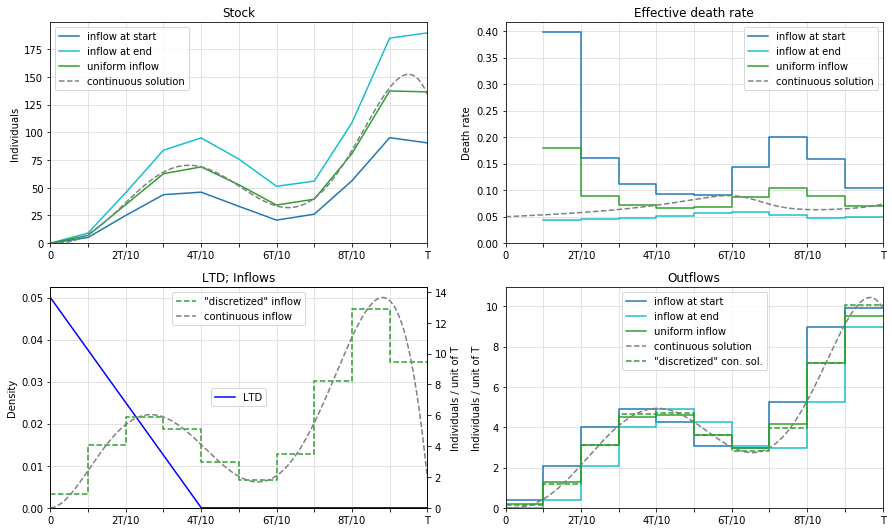

In [24]:
# -- plot the figure
fig = plt.figure(figsize = (12.5, 7.5))
plt.rcParams.update({'font.size': 10})

# Stock
ax1 = plt.subplot(221, fc = 'w')
#plt.plot(t, Sd, linestyle = '-', color = 'tab:orange', label = 'constant death rate')
#plt.plot(t, So, color='tab:red', label = 'approach Lauinger')
plt.plot(t, Ss, color='tab:blue', label = 'inflow at start')
plt.plot(t, Se, color='tab:cyan', label = 'inflow at end')
plt.plot(t, Su, color='tab:green', label = 'uniform inflow')
plt.plot(t1, s_values, color='grey', label='continuous solution', linestyle = '--')
plt.legend(facecolor = 'w', fontsize = '10', loc = 'upper left')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.ylabel('Individuals')
plt.title('Stock')
plt.grid(color='gainsboro')

if hor==1:
    t3 = t2[2:]
else:
    t3 = t2[1:]

# Effective Death Rate
ax2 = plt.subplot(222, facecolor = 'w')
#plt.plot(t3, dp(np.ones(N-1)*d,hor), linestyle = '-', color = 'tab:orange', label = 'constant death rate')
#plt.plot(t3, dp(Do/dt,hor), linestyle = '-', color = 'tab:red', label = 'approach Lauinger')
plt.plot(t3, dp(Ds/dt,hor), linestyle = '-', color = 'tab:blue', label = 'inflow at start')
plt.plot(t3, dp(De/dt,hor), linestyle = '-', color = 'tab:cyan', label = 'inflow at end')
plt.plot(t3, dp(Du/dt,hor), linestyle = '-', color = 'tab:green', label = 'uniform inflow')
plt.plot(t1[1:], (o_values/s_values)[1:], linestyle = '--',  color = 'grey', label = 'continuous solution')

plt.legend(facecolor = 'w', fontsize = '10', loc = 'upper right')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.ylabel('Death rate')
plt.title('Effective death rate')
plt.grid(color='gainsboro')

# LTD; Inflows
ax3=[]
ax3.append(plt.subplot(223, fc = 'w'))

plt.plot(t1,pdf(t1), color='blue', label = 'LTD')
bottom, top = ax3[0].get_ylim()
ax3[0].set_ylim(0,top)
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.legend(facecolor = 'w', fontsize = '10', loc = 'center')
plt.ylabel('Density')
plt.title('LTD; Inflows')
plt.grid(color='gainsboro')

#create plot on secondary y-axis of upper subplot
ax3.append(ax3[0].twinx())

plt.plot(t2, dp(I/dt,hor), label = '"discretized" inflow', color = 'tab:green', linestyle = '--')
plt.plot(t1, i_values, label='continuous inflow', color = 'grey', linestyle = '--')
plt.legend(facecolor = 'w', fontsize = '10', loc = 'upper center')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
plt.ylabel('Individuals / unit of T')

# Outflows
ax4 = plt.subplot(224, facecolor = 'w')
#plt.plot(t2, dp(Od/dt,hor), label = 'constant death rate', color = 'tab:orange')
#plt.plot(t2, dp(Oo/dt,hor), label='approach Lauinger', color = 'tab:red')
plt.plot(t2, dp(Os/dt,hor), label='inflow at start', color = 'tab:blue')
plt.plot(t2, dp(Oe/dt,hor), label='inflow at end', color = 'tab:cyan')
plt.plot(t2, dp(Ou/dt,hor), label='uniform inflow', color = 'tab:green')
plt.plot(t1, o_values, label='continuous solution', color = 'grey', linestyle = '--')
plt.plot(t2, dp(mean_o,hor), label = '"discretized" con. sol.', color = 'tab:green', linestyle = '--')
plt.legend(facecolor = 'w', fontsize = '10', loc = 'upper center')
plt.xlim([0, T])
plt.ylim(0, plt.ylim()[1])
#plt.xticks([0*T, 0.25*T, 0.5*T, 0.75*T, 1*T], [0, 'T/4', 'T/2', '3T/4', 'T'])
plt.xticks([0*T, 0.1*T, 0.2*T, 0.3*T, 0.4*T, 0.5*T, 0.6*T, 0.7*T, 0.8*T, 0.9*T, 1.0*T], [0, '', '2T/10', '', '4T/10', '', '6T/10', '', '8T/10', '', 'T'])
# plt.xlabel('Time')
plt.ylabel('Individuals / unit of T')
plt.title('Outflows')
plt.grid(color='gainsboro')
# optimize layout
fig.tight_layout()
#fig.savefig('Flows and stocks (inflow-driven model).pdf',bbox_inches='tight')
#fig.savefig('Flows and stocks (inflow-driven model).png',bbox_inches='tight', dpi=600)